# This notebook trying to form the pipeline of downloading data from the online database

#### Author: Jax
#### Date: 06-14-2023


In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision
sns.set(rc = {'figure.figsize':(18,10)})
from scipy.ndimage import gaussian_filter1d

In [3]:
def query_from_influxdb(_url=None,
                        _token=None,
                        _org=None,
                        _id=None,
                        _bucket_name=None,
                        _columns_to_drop=None,
                        _measurement=None,
                        _field=None, ):
    
    """
        Function to query InfluxDB using influxdb-python-client library from https://github.com/influxdata/influxdb-client-python
            :param _measurement: Available options are flood-sensor-tidal-sensor-rain-gauge,weather,etc. Default is flood-sensor
            :param _field: Available options include batt_v and cloud_percent 
            :param _url: InfluxDB url
            :param _token: API token with read-access
            :param _org: InfluxDB organization name
            :param _id: Sensor/Deployment ID
            :param _bucket_name: Name of the bucket
            :param _columns_to_drop: Array-like column names to be dropped
        :returns a dataframe with all columns except dropped ones if any
    """
    result = []
    p = {"_id_value": _id,
         "_bucket_name": _bucket_name,
         "_measurement": _measurement, 
         "_field": _field, }


    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000) as client:
        query_api = client.query_api()
        if _measurement=="weather":  
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                  |> range(start: -40d, stop: now())
                                                  |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                  |> filter(fn: (r) => r["_field"] == _field)
                                                  |> filter(fn: (r) => r["sensor_id"] == _id_value)
                                                  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)   
        else:        
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                |> range(start: -40d)       
                                                |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                |> filter(fn: (r) => r["deployment_id"] == _id_value)
                                                |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)

        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True) #result
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])

    return result

In [4]:
sensor_info = pd.read_excel('sensor_information.xlsx')[['deployment_id','date_down', 
                                                        'lat', 'lon', 'height_ground_mm',
                                                       'deploy_type']][1:]

In [5]:
sensor_info.head()

,deployment_id,date_down,lat,lon,height_ground_mm,deploy_type
1,daily_gentle_beetle,-,40.675855,-73.983944,NaN,pluvial
2,widely_proud_lizard,2021-12-10 00:00:00,40.673654,-73.995396,3000.0,pluvial
3,overly_heroic_squid,-,40.673401,-73.994892,NaN,pluvial
4,weekly_poetic_guinea,-,40.676281,-73.984089,2700.0,pluvial
5,vastly_saving_whale,-,40.673267,-74.008418,NaN,pluvial


In [6]:
df= query_from_influxdb(_url='https://influxdb.floodlabs.nyc/',
                           _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                           _org='floodnet',
                           _id='overly_heroic_squid',
                          _bucket_name='floodnet-live',
                           _measurement="flood-sensor",
                           _field="batt_v",).reset_index()[['time', 'deployment_id', 'error_flag','batt_v']]
df.head()

,time,deployment_id,error_flag,batt_v
0,2023-05-12 14:36:50.798000+00:00,overly_heroic_squid,0,4.13
1,2023-05-12 14:37:53.637000+00:00,overly_heroic_squid,0,4.13
2,2023-05-12 14:38:57.091000+00:00,overly_heroic_squid,0,4.13
3,2023-05-12 14:39:59.891000+00:00,overly_heroic_squid,0,4.13
4,2023-05-12 14:41:03.186000+00:00,overly_heroic_squid,0,4.13


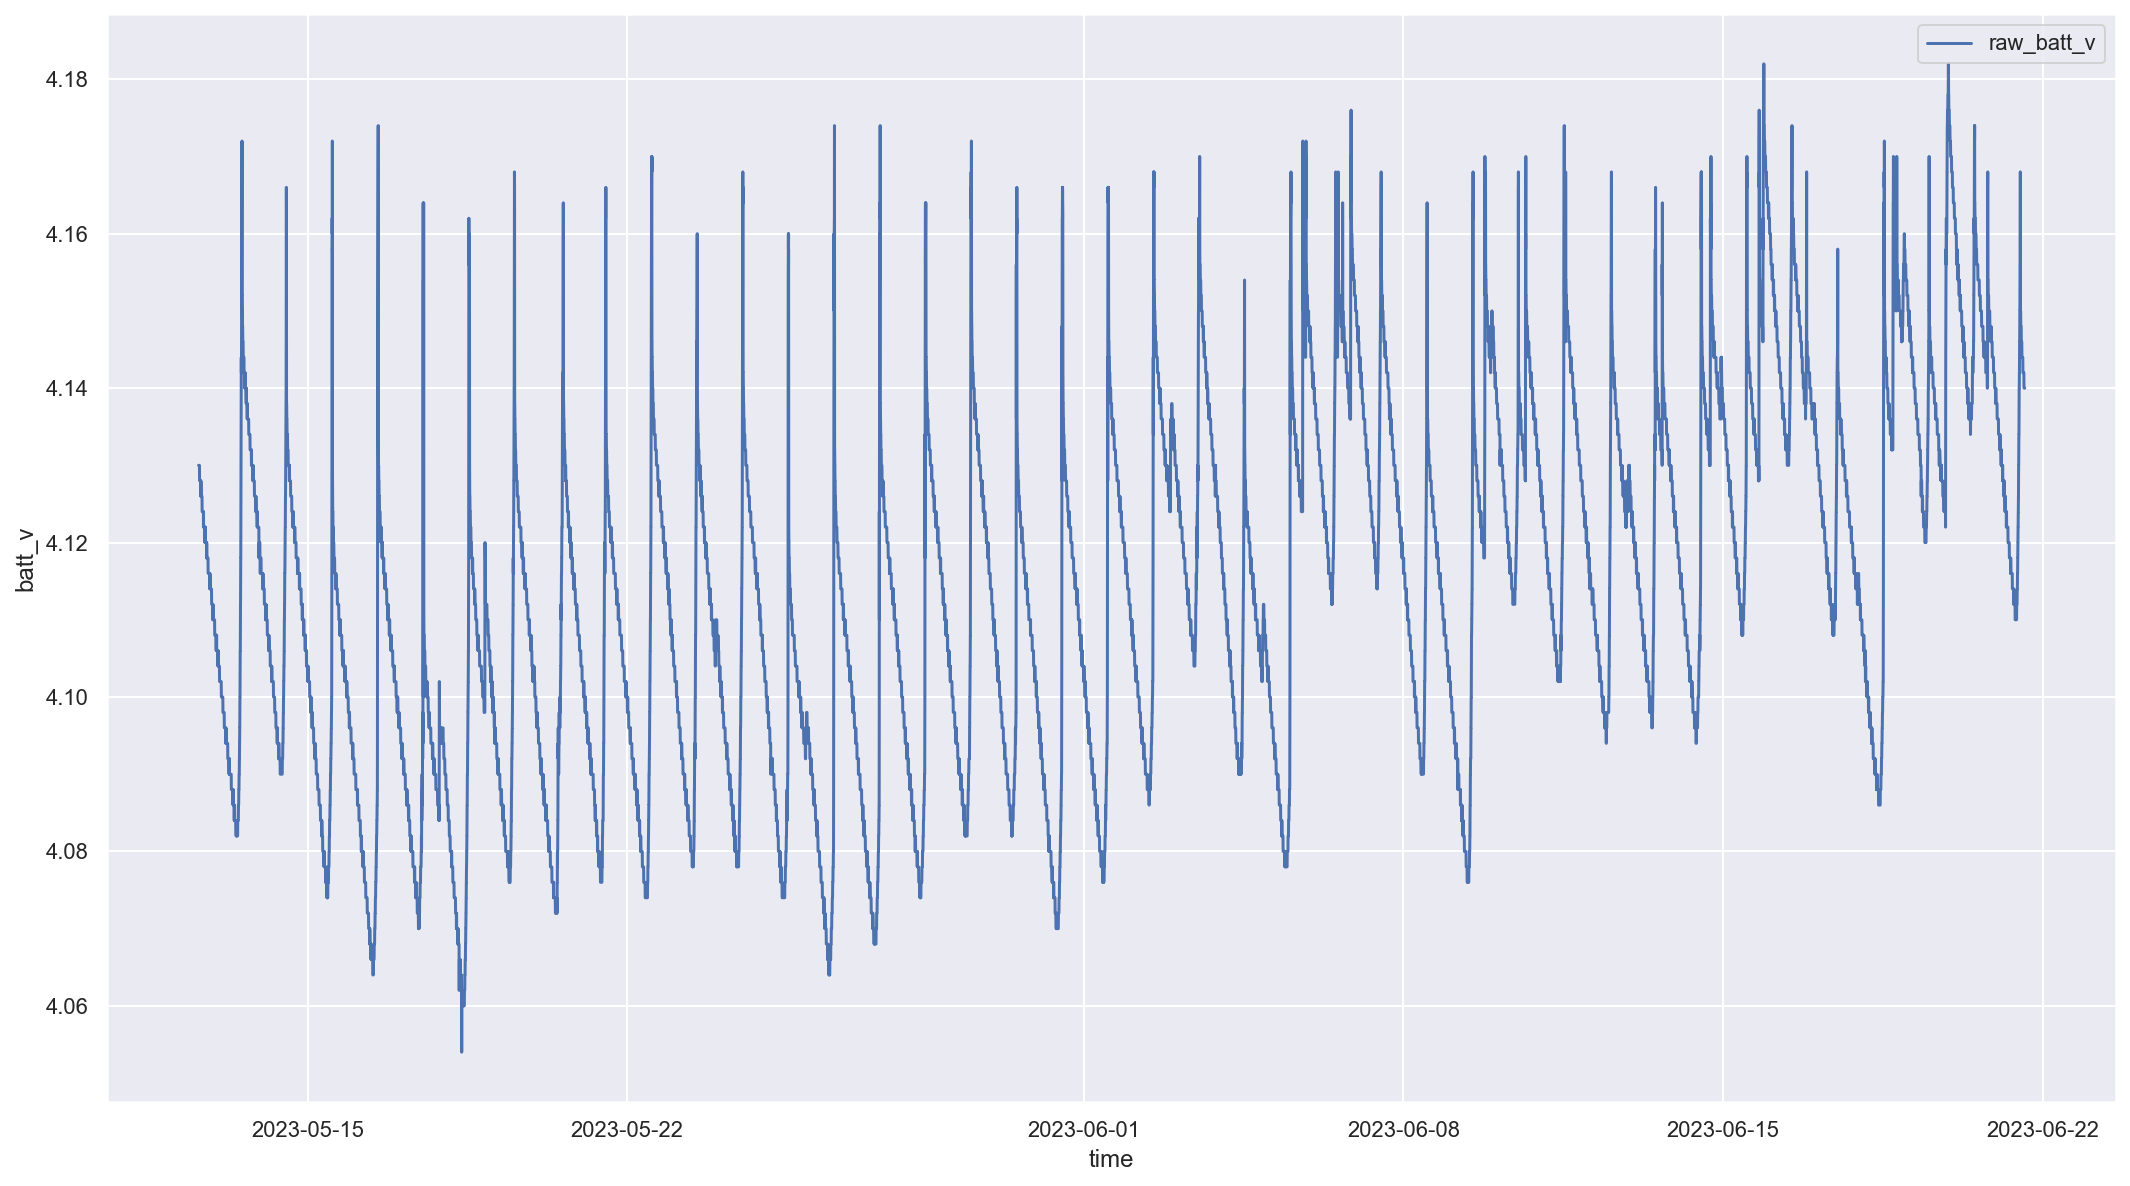

In [7]:
ax = sns.lineplot(data = df.reset_index(), x = 'time', y = 'batt_v', label= 'raw_batt_v')
plt.savefig('classic_batt_pattern')

## Try get all batt_v data by simple for loop and smooth by gaussian 1d filter

In [8]:
lis = []
c = 0
for name in sensor_info['deployment_id']:
    try:
      sub = query_from_influxdb(_url='https://influxdb.floodlabs.nyc/',
                            _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                            _org='floodnet',
                            _id=name,
                            _bucket_name='floodnet-live',
                            _measurement="flood-sensor",
                            _field="batt_v",).reset_index()[['time', 'deployment_id', 'error_flag','batt_v']]
      lis.append(sub)
    except:
      pass
    #print(name)
all_batt = pd.concat(lis)
all_batt.shape

(1655261, 4)

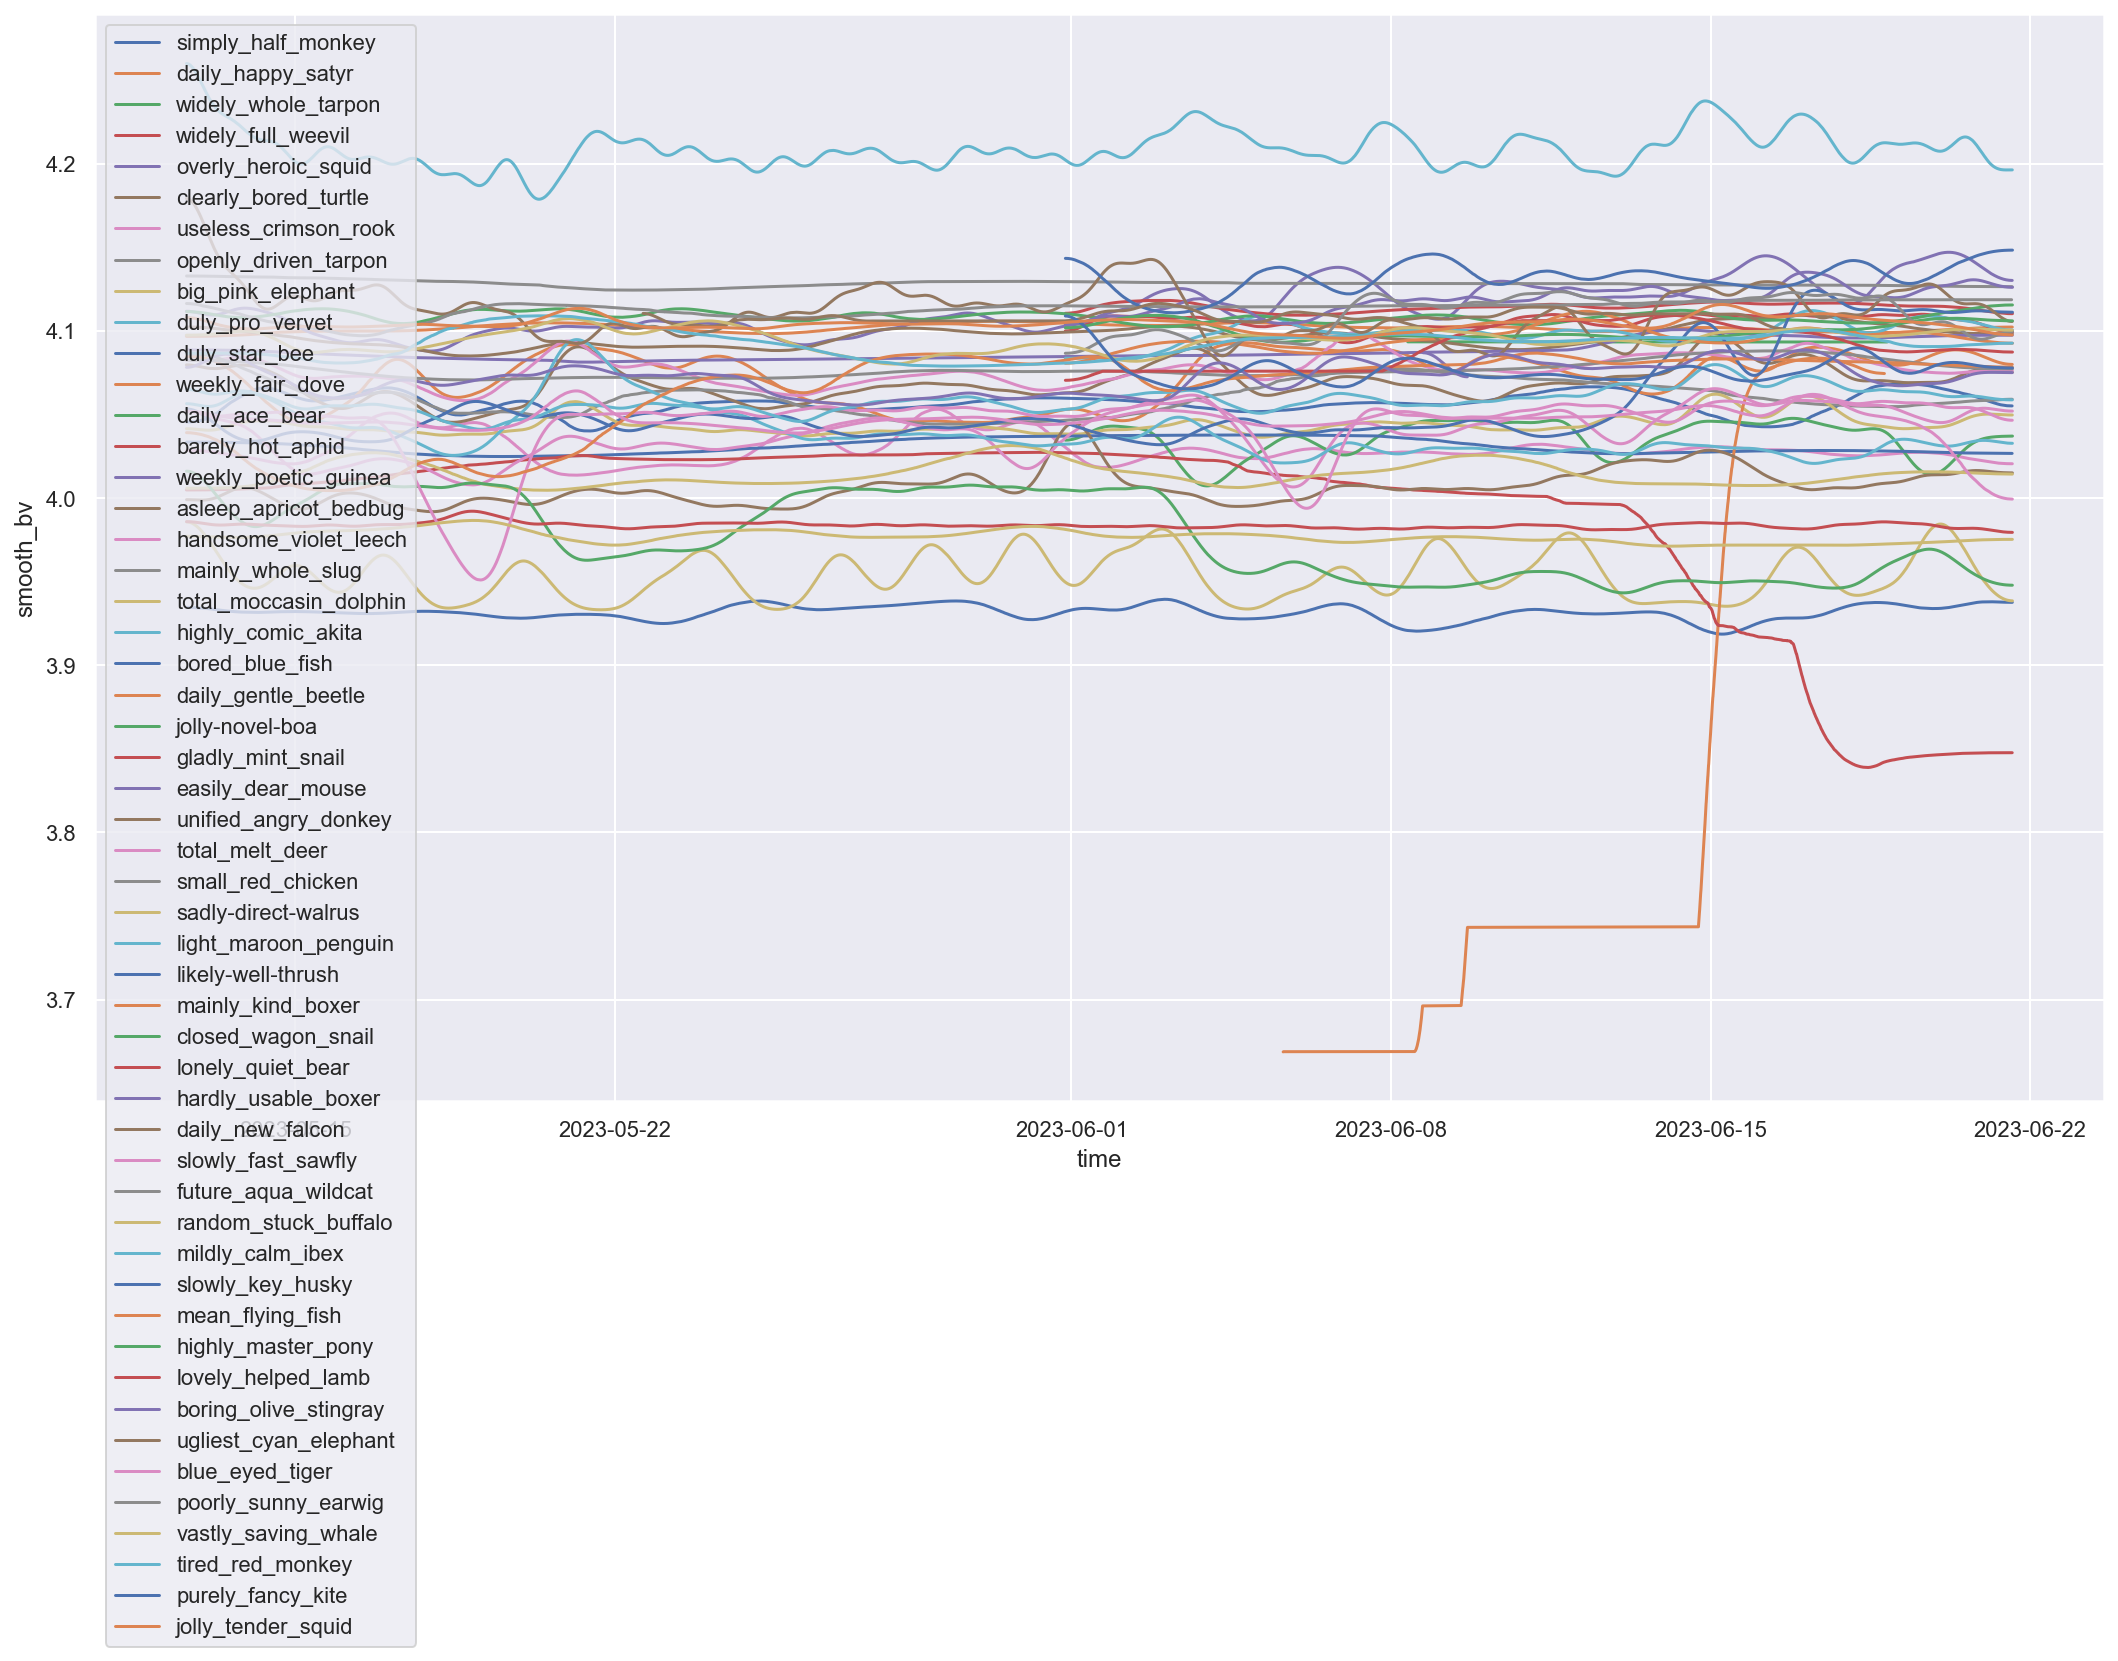

In [9]:
fig, ax = plt.subplots(figsize=(18,10))
dplis = list({i for i in all_batt['deployment_id']})
k = 0
for s in dplis:
  # if k != 13:
    sub = all_batt.loc[all_batt['deployment_id'] == s].copy().dropna()
    sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=600)
    sns.lineplot(data = sub, x = 'time', y = 'smooth_bv',label = s)
plt.savefig('52_sensors_20d_batt_pattern_40d')

/var/folders/lc/lwj679010v9dq_hdbg2xjrbm0000gn/T/ipykernel_69172/279793765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)


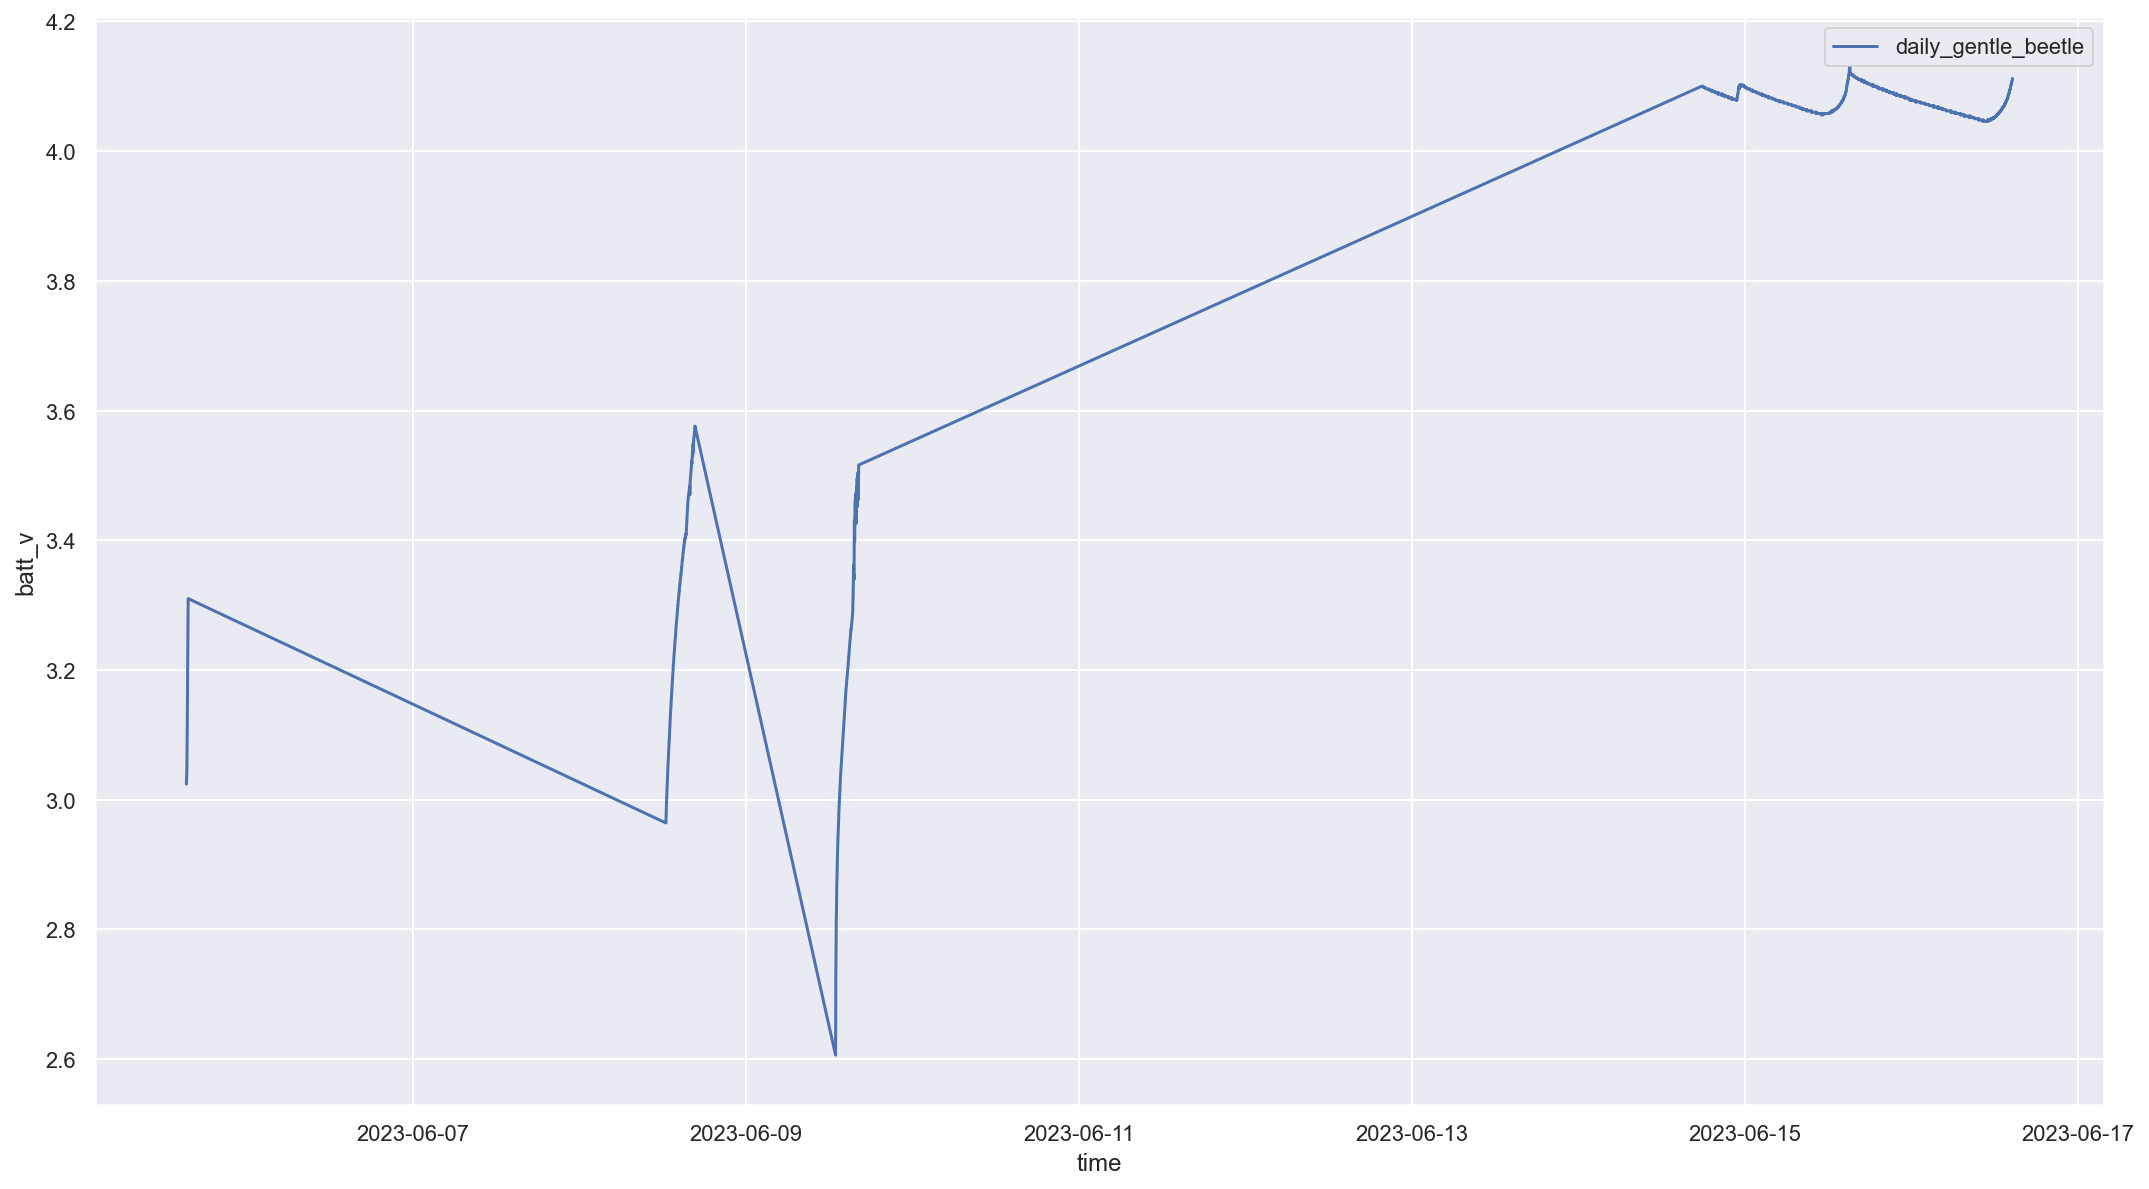

In [45]:
# the wierd case
sub = all_batt.loc[all_batt['deployment_id'] == 'daily_gentle_beetle'].dropna()
sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'batt_v', label = 'daily_gentle_beetle')
plt.savefig('wierd_case_no_smooth')


In [47]:
sub

,time,deployment_id,error_flag,batt_v
0,2023-06-05 15:16:37.443000+00:00,daily_gentle_beetle,0,3.024
1,2023-06-05 15:16:45.251000+00:00,daily_gentle_beetle,0,3.024
2,2023-06-05 15:17:48.181000+00:00,daily_gentle_beetle,0,3.028
3,2023-06-05 15:18:51.454000+00:00,daily_gentle_beetle,0,3.032
4,2023-06-05 15:19:54.821000+00:00,daily_gentle_beetle,0,3.036
...,...,...,...,...
2564,2023-06-16 14:24:49.628000+00:00,daily_gentle_beetle,0,4.106
2565,2023-06-16 14:25:53.096000+00:00,daily_gentle_beetle,0,4.108
2566,2023-06-16 14:29:01.188000+00:00,daily_gentle_beetle,0,4.110
2567,2023-06-16 14:30:04.386000+00:00,daily_gentle_beetle,0,4.110


## Try to smooth by taking period average of the battary

In [43]:
df.head()

,time,deployment_id,error_flag,batt_v
0,2023-05-27 14:19:23.098000+00:00,overly_heroic_squid,0,4.128
1,2023-05-27 14:20:26.278000+00:00,overly_heroic_squid,0,4.128
2,2023-05-27 14:21:29.315000+00:00,overly_heroic_squid,0,4.128
3,2023-05-27 14:23:35.195000+00:00,overly_heroic_squid,0,4.126
4,2023-05-27 14:24:38.192000+00:00,overly_heroic_squid,0,4.126


In [44]:
for i in df['time']:
    print(type(i))
    break

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [48]:
df.groupby(by = [df['time'].dt.hour]).batt_v.mean()

time
0     4.120185
1     4.117202
2     4.114325
3     4.111631
4     4.108835
5     4.106180
6     4.103371
7     4.100707
8     4.097998
9     4.095367
10    4.095400
11    4.106487
12    4.139695
13    4.141780
14    4.136745
15    4.133239
16    4.132058
17    4.129984
18    4.128455
19    4.129742
20    4.127777
21    4.127313
22    4.125887
23    4.123211
Name: batt_v, dtype: float64

In [54]:
avg = df.groupby(by = [df['time'].dt.date]).batt_v.mean()
avg.reset_index()

,time,batt_v
0,2023-05-27,4.113869
1,2023-05-28,4.104689
2,2023-05-29,4.110558
3,2023-05-30,4.104679
4,2023-05-31,4.100330
5,2023-06-01,4.107578
6,2023-06-02,4.116595
7,2023-06-03,4.127031
8,2023-06-04,4.108613
9,2023-06-05,4.114060


In [61]:
date_check = all_batt.groupby(by = ['deployment_id', all_batt['time'].dt.date]).batt_v.mean().reset_index()
date_check.head()

,deployment_id,time,batt_v
0,asleep_apricot_bedbug,2023-05-27,4.079644
1,asleep_apricot_bedbug,2023-05-28,4.068192
2,asleep_apricot_bedbug,2023-05-29,4.068222
3,asleep_apricot_bedbug,2023-05-30,4.064743
4,asleep_apricot_bedbug,2023-05-31,4.061984


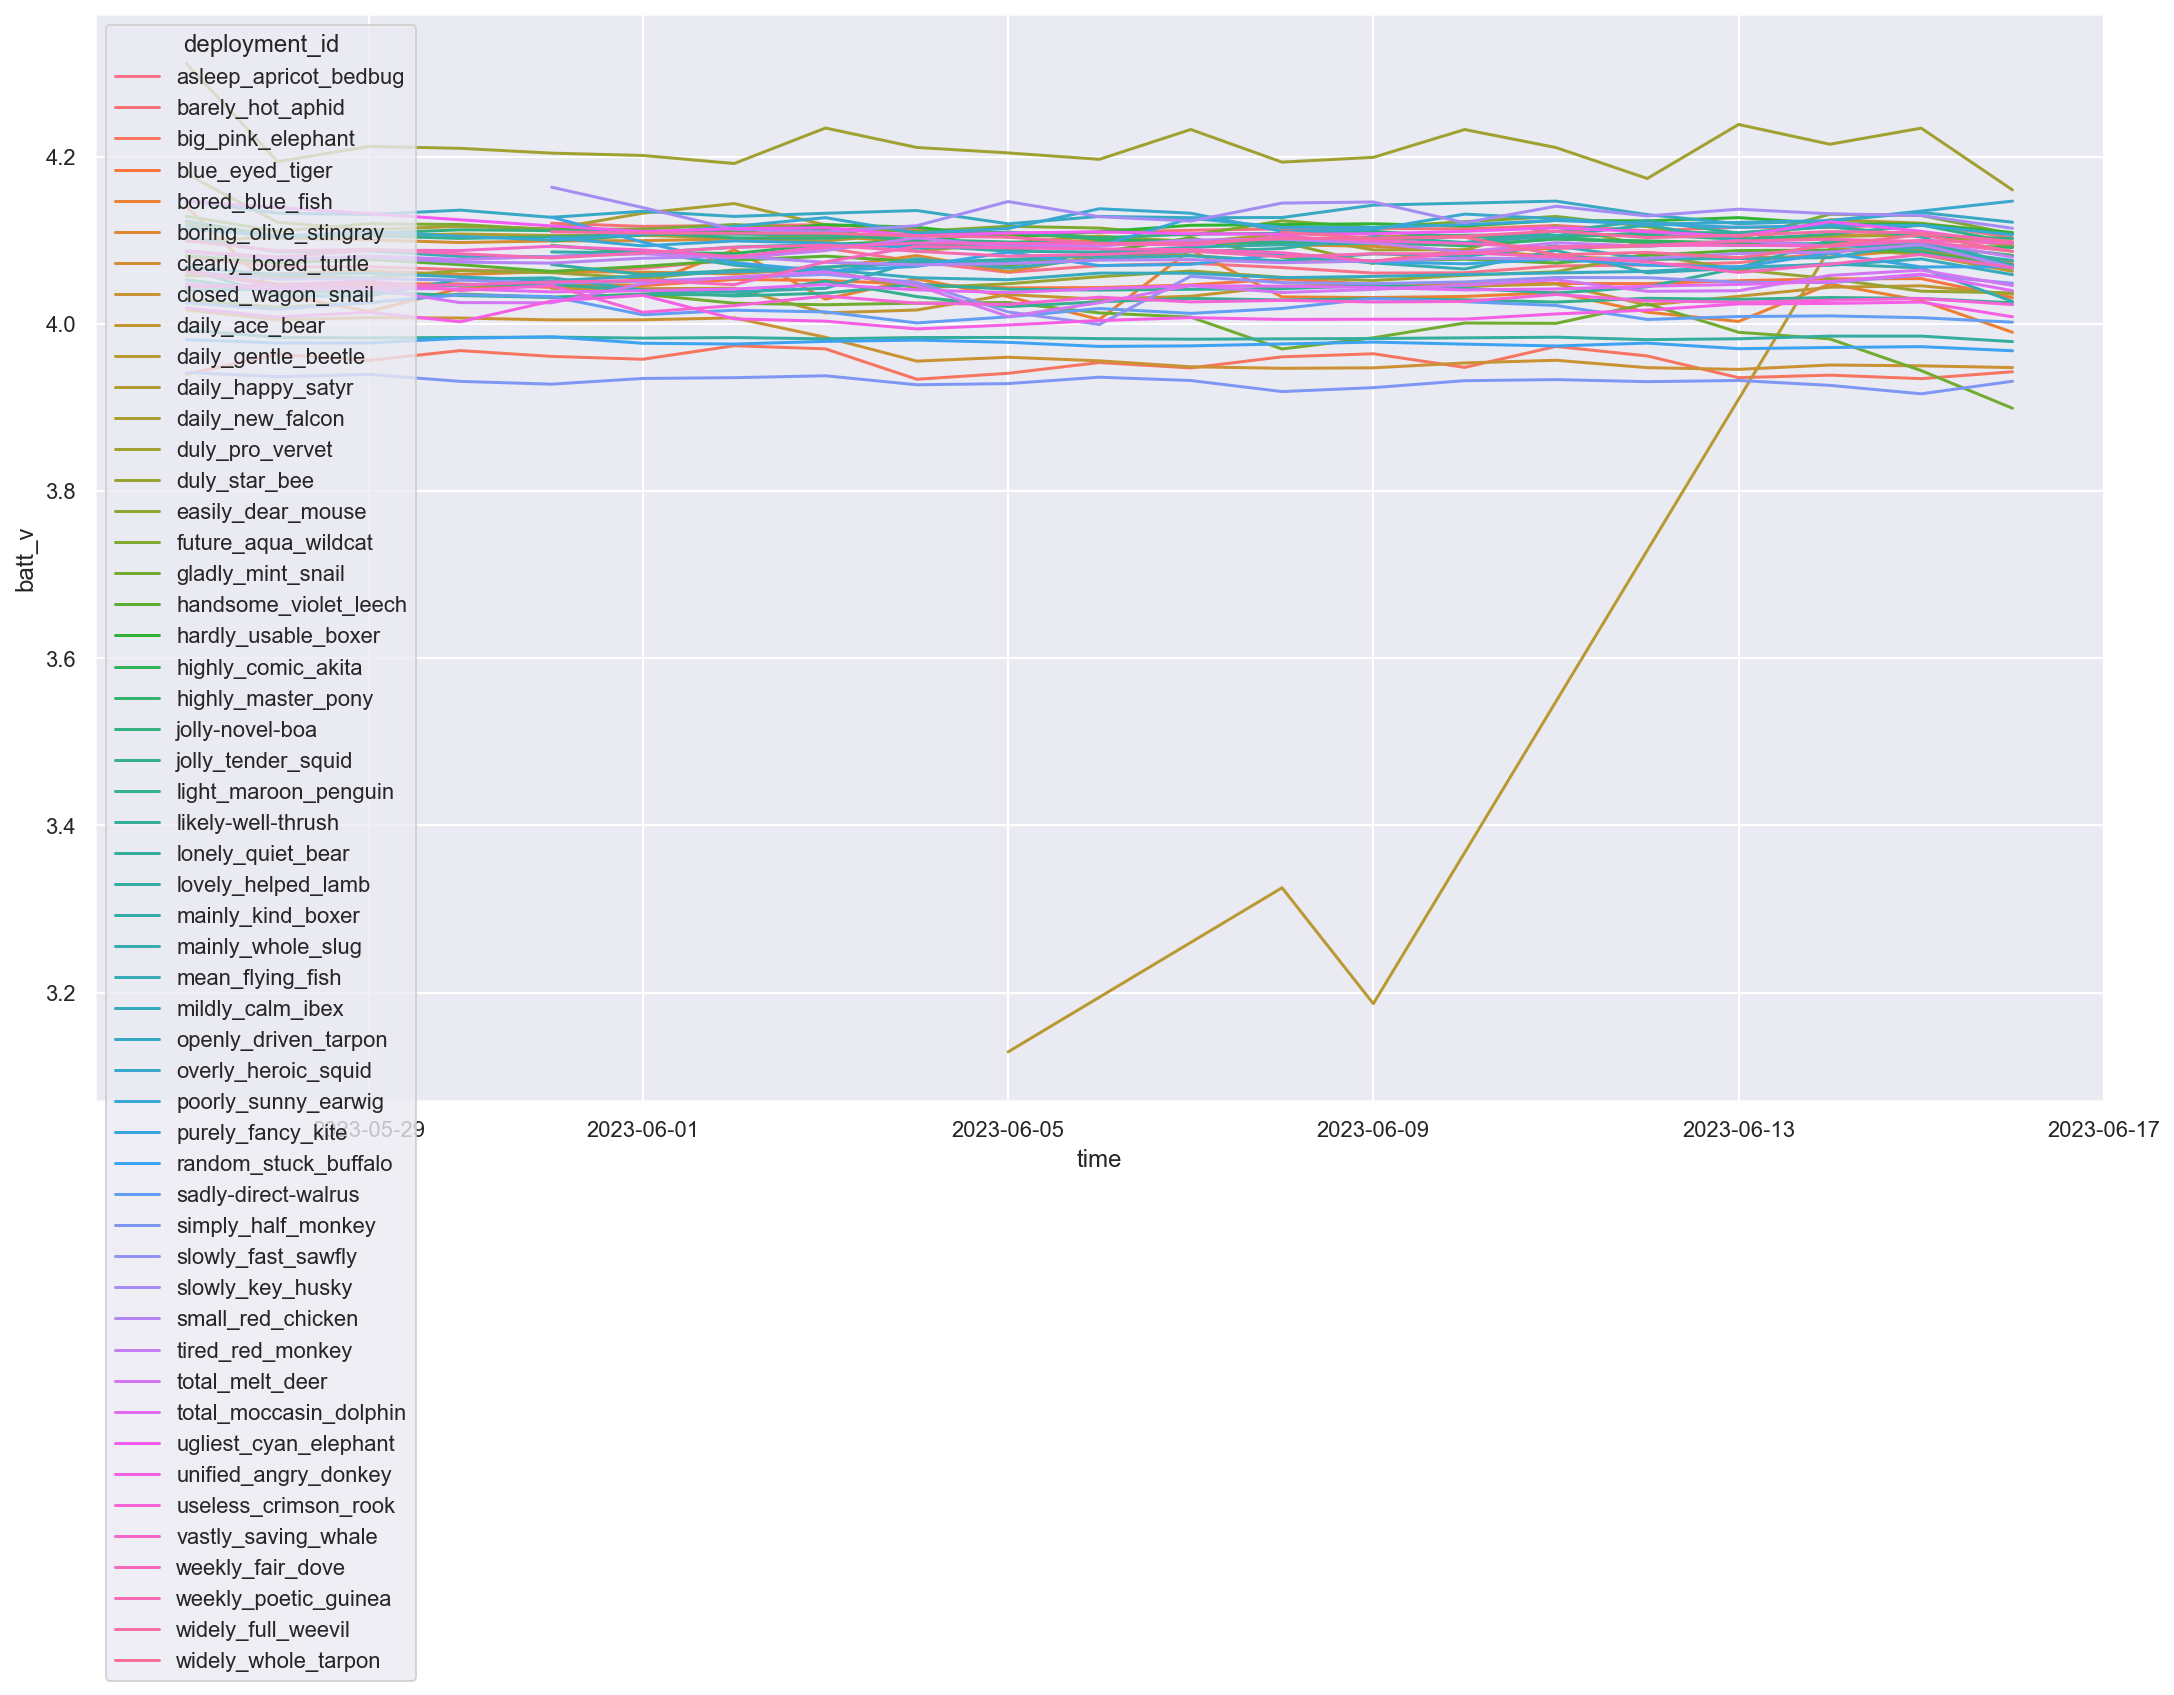

In [63]:
sns.lineplot(data = date_check, x = 'time',y = 'batt_v', 
             hue = 'deployment_id')
plt.savefig('avg_by_date')

In [67]:
hour_check = all_batt.groupby(by = ['deployment_id', all_batt['time'].dt.hour]).batt_v.mean().reset_index()
hour_check.head()

,deployment_id,time,batt_v
0,asleep_apricot_bedbug,0,4.069842
1,asleep_apricot_bedbug,1,4.067055
2,asleep_apricot_bedbug,2,4.064228
3,asleep_apricot_bedbug,3,4.061412
4,asleep_apricot_bedbug,4,4.058521


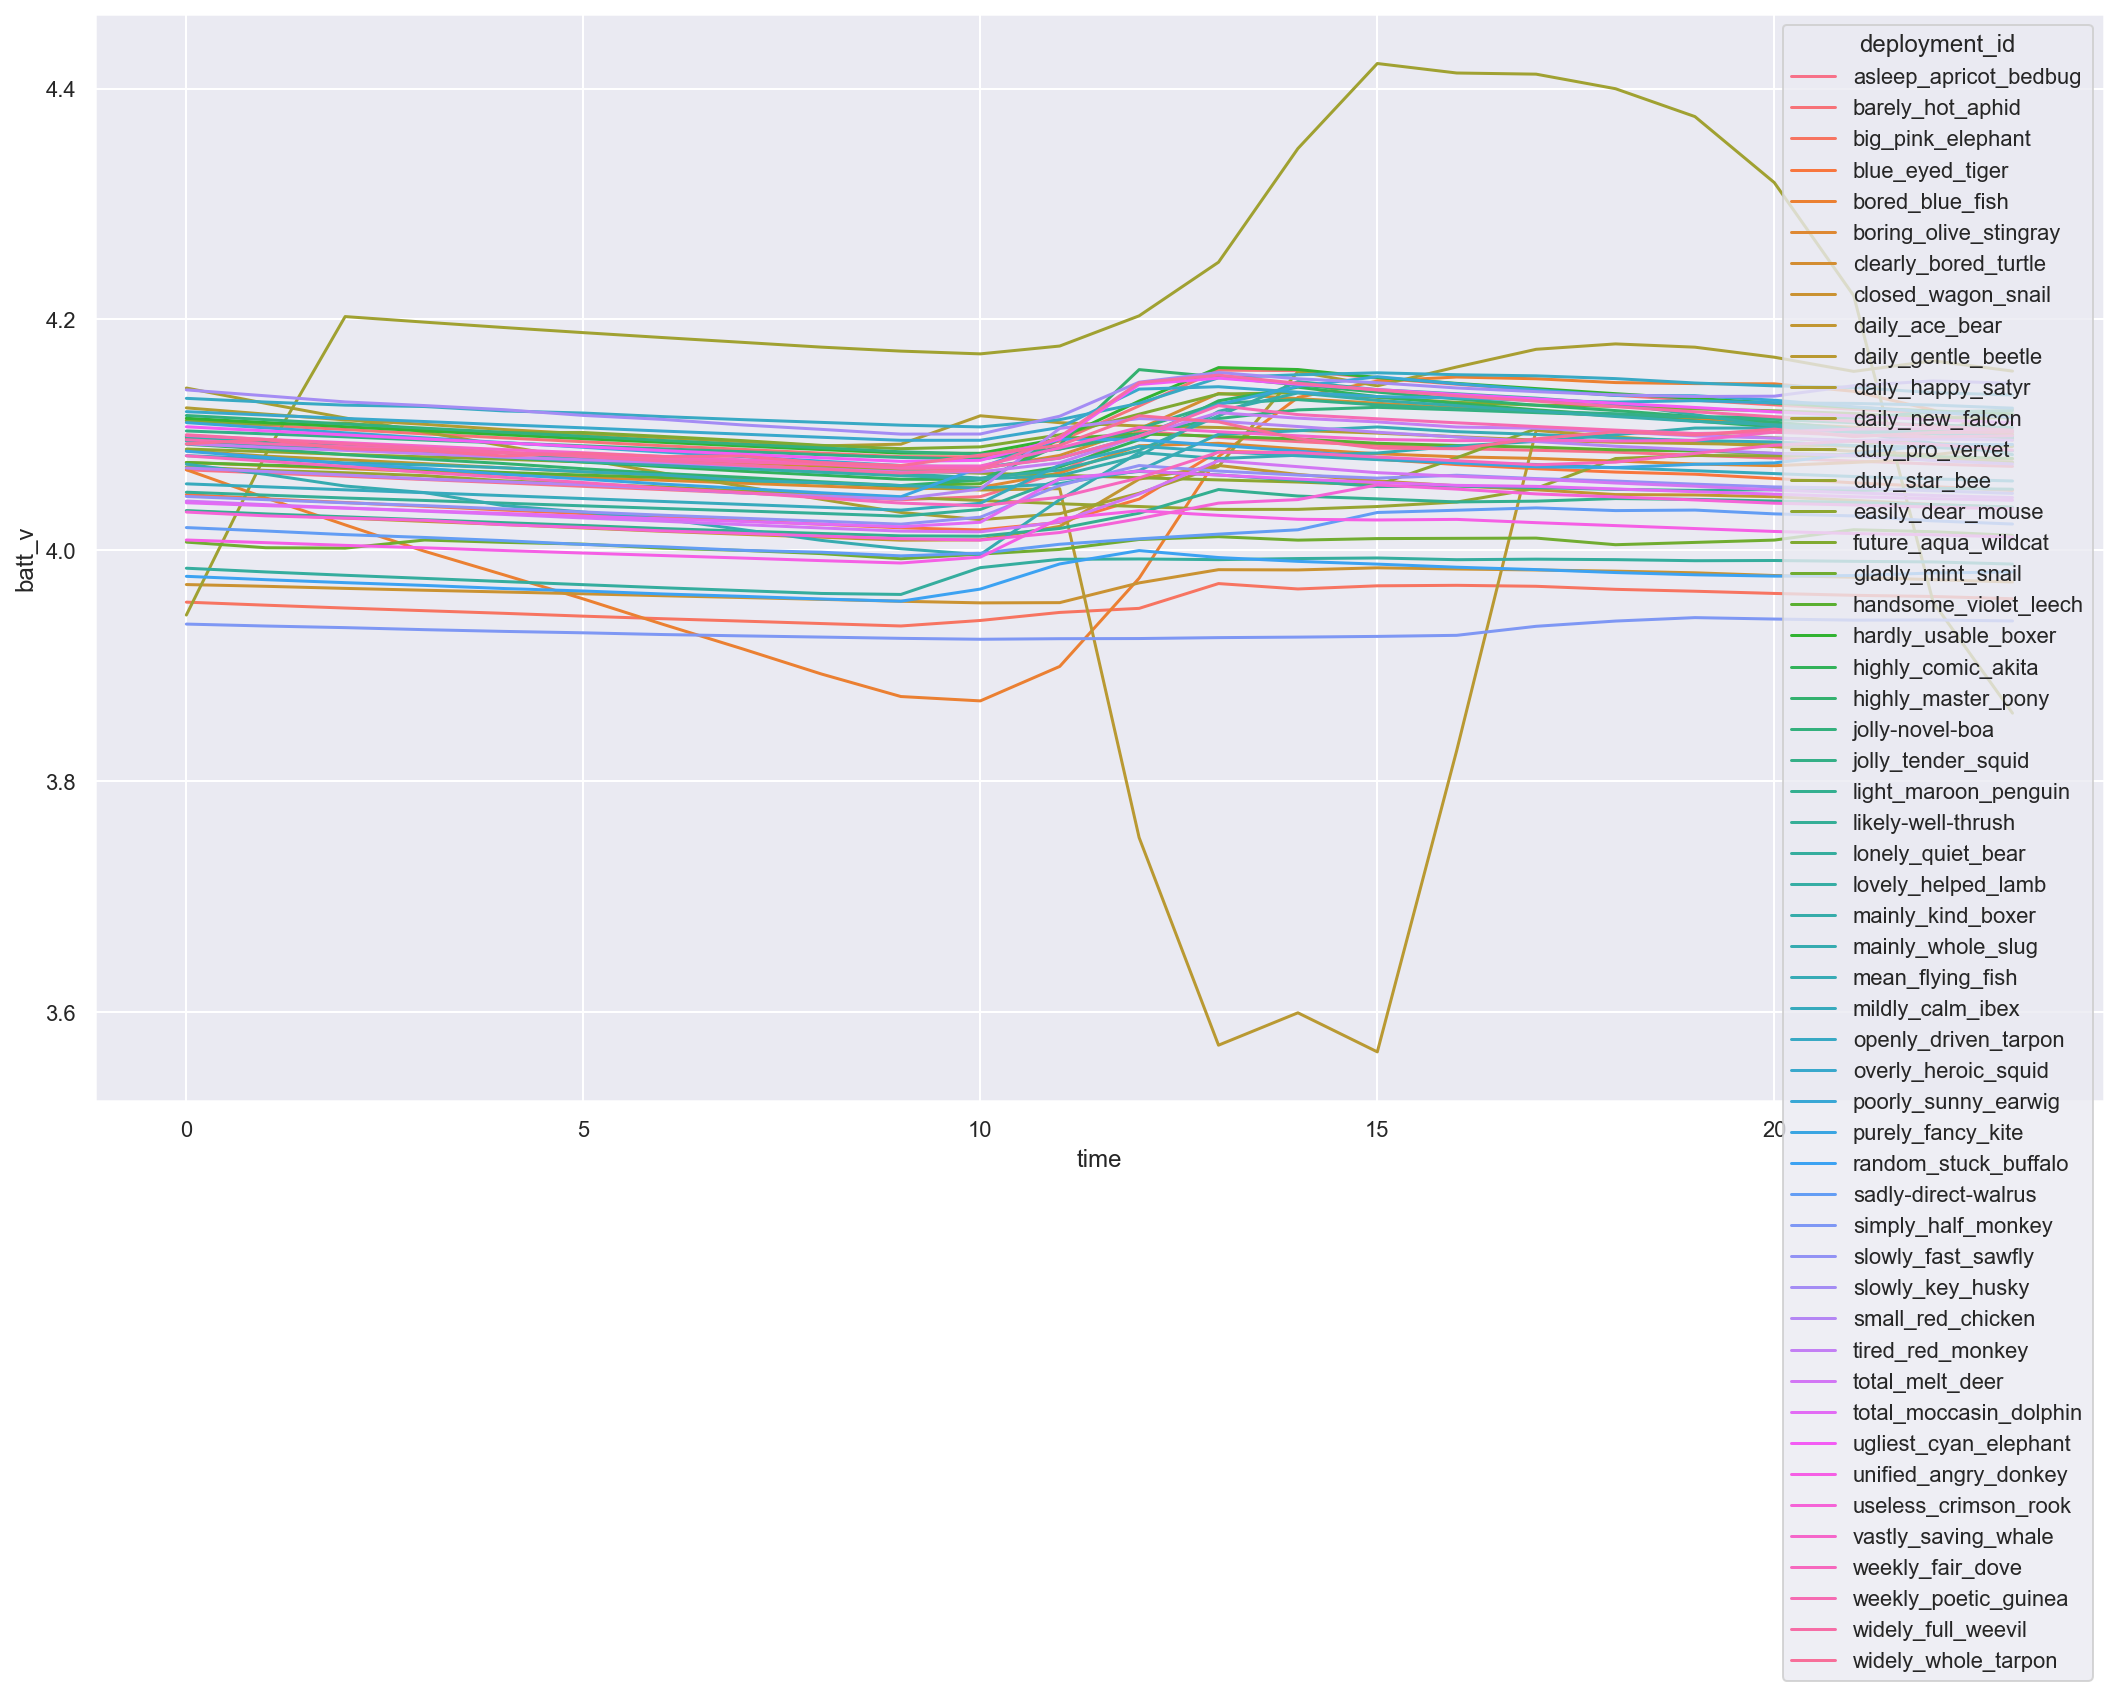

In [68]:
sns.lineplot(data = hour_check, x = 'time',y = 'batt_v', 
             hue = 'deployment_id')
plt.savefig('avg_by_hour')